# Handout #5

In [1]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import pickle
import requests
import multiprocessing

from bs4 import BeautifulSoup
from queue import Empty
from queue import Queue
from pathlib import Path
from bs4.element import Comment
from nltk.corpus import stopwords 
from urllib.parse import urljoin
from urllib.parse import urlparse
from concurrent.futures import ThreadPoolExecutor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

---
Page `66 - 67` - Power iteration

In [2]:
# Page 66
x0 = np.matrix([1/7] * 7)
P = np.matrix([
        [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7],
        [25/56, 3/140, 25/56, 3/140, 3/140, 3/140, 3/140],
        [3/140, 3/140, 3/140, 3/140, 61/70, 3/140, 3/140],
        [3/140, 3/140, 25/56, 3/140, 3/140, 3/140, 25/56],
        [25/56, 3/140, 3/140, 3/140, 3/140, 25 /56, 3/140],
        [3/140, 3/140, 61/70, 3/140, 3/140, 3/140, 3/140],
        [3/140, 3/140, 25/56, 3/140, 3/140, 25/56, 3/140],
    ])

prev_Px = x0
Px = x0*P
i=0
while(any(abs(np.asarray(prev_Px).flatten()-np.asarray(Px).flatten()) > 1e-8)):
    i+=1
    prev_Px = Px
    Px = Px * P

print('Converged in {0} iterations: {1}'.format(i, np.asarray(Px).flatten()))

Converged in 39 iterations: [0.16911688 0.04196419 0.25324048 0.04196419 0.2572186  0.17669667
 0.05979897]


---
Page `68 - 70` - The PageRank score

In [3]:
# Page 68,69
class Pr:
    def __init__(self, alpha):
        self.crawled_folder = Path(os.path.abspath('')).parent / 'crawled/'
        self.alpha = alpha

    def url_extractor(self):
        url_maps = {}
        all_urls = set()

        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                with open(os.path.join(self.crawled_folder, file)) as f:
                    j = json.load(f)
                    
                all_urls.add(j['url'])
                for s in j['url_lists']:
                    all_urls.add(s)

                url_maps[j['url']] = list(set(j['url_lists']))
        
        all_urls = list(all_urls) 
        return url_maps, all_urls

    def pr_calc(self):
        url_maps, all_urls = self.url_extractor()
        num_urls = len(all_urls)
        index_map = {url: i for i, url in enumerate(all_urls)}  # Map URLs to indices

        # Use NumPy array instead of Pandas DataFrame
        url_matrix = np.full((num_urls, num_urls), (1 - self.alpha) / num_urls)

        for url, links in url_maps.items():
            if links:
                i = index_map[url]
                url_matrix[i, [index_map[l] for l in links]] += self.alpha / len(links)

        # Handle rows with no outgoing links
        dangling_nodes = np.where(url_matrix.sum(axis=1) == 0)[0]
        url_matrix[dangling_nodes, :] = 1 / num_urls

        # Convert to NumPy matrix for faster multiplication
        P = np.asmatrix(url_matrix)
        x0 = np.asmatrix(np.full((1, num_urls), 1 / num_urls))

        prev_Px = x0
        Px = x0 @ P  # Matrix multiplication
        i = 0
        while np.linalg.norm(prev_Px - Px, ord=1) > 1e-8:  # Faster stopping condition
            i += 1
            prev_Px = Px
            Px = Px @ P

        print(f'Converged in {i} iterations')
        scores = np.asarray(Px).flatten()
        self.pr_result = pd.DataFrame(scores, index=all_urls, columns=['score'])



In [4]:
s = Pr(alpha=0.85)
s.pr_calc()

Converged in 14 iterations


In [5]:
# Page 70
print(s.pr_result.sort_values(by='score', ascending=False))

                                                           score
https://www.cmu.ac.th/en/                           4.916690e-09
https://www.cmu.ac.th/en/#content                   4.011912e-09
https://www.cmu.ac.th/                              3.183319e-09
https://shop.cmu.ac.th                              3.051538e-09
https://shop.cmu.ac.th/                             3.030638e-09
...                                                          ...
https://www.cmu.ac.th/content/Article/2024/16fa...  2.217631e-12
https://www.cmu.ac.th/content/Article/2024/16fa...  2.217631e-12
https://www.cmu.ac.th/content/Article/2024/16fa...  2.217631e-12
https://www.cmu.ac.th/content/Article/2024/16fa...  2.217631e-12
https://www.cmu.ac.th/content/Article/2024/16fa...  2.217631e-12

[41599 rows x 1 columns]


`pr_calc result:`

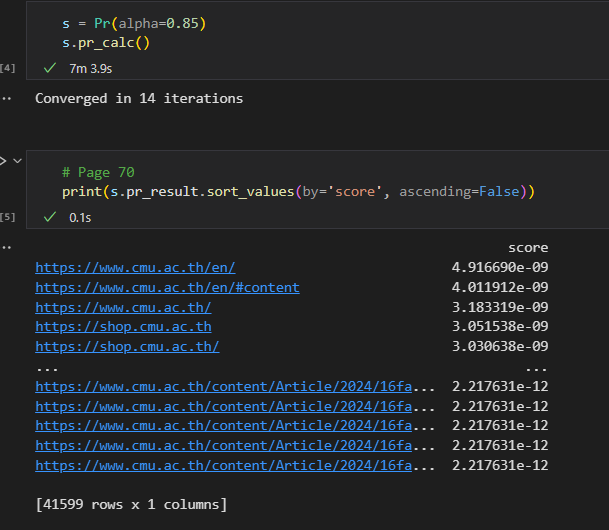

---
Page `71 - 75` - Integrating the PageRank score with Elasticsearch


In [6]:
# Page 71
from elasticsearch import Elasticsearch

class IndexerWithPR:

    def __init__(self):
        self.crawled_folder = Path(os.path.abspath('')).parent / 'crawled/'
        with open(self.crawled_folder / 'url_list.pickle', 'rb') as f:
            self.file_mapper = pickle.load(f)
        
        self.es_client = Elasticsearch("localhost:9200", basic_auth=("elastic", "7L4*ufX=xVOj7qa9LDj="), ca_certs="~/http_ca.crt")
        self.pr = Pr(alpha=0.85)

    def run_indexer(self):
        self.pr.pr_calc()
        self.es_client.options(ignore_status=[400, 404]).indices.delete(index='simple')
        self.es_client.options(ignore_status=[400]).indices.create(index='simple')

        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file)))
                j['id'] = j['url']
                j['pagerank'] = self.pr.pr_result.loc[j['id']].score
                print(j)
            self.es_client.index(index='simple', body=j)

In [7]:
# Page 73
from flask import Flask, request
from elasticsearch import Elasticsearch
import pandas as pd
import time

app = Flask(__name__)
app.es_client = Elasticsearch("https://localhost:9200", basic_auth=("elastic","_Z9BSk2zcMuFD=-1LlAX"), ca_certs="~/http_ca.crt")

@app.route('/search_es_pr', methods=['GET'])
def search_es_pr():
    start = time.time()
    response_object = {'status': 'success'}
    argList = request.args.to_dict(flat=False)
    query_term=argList['query'][0]
    results = app.es_client.search(index='simple', source_excludes=['url_lists'], size=100,
    query={"script_score": {"query": { "match": { "text": query_term } }, "script": {"source":"_score * doc['pagerank'].value"}}})
    end = time.time()
    total_hit = results['hits']['total']['value']
    results_df = pd.DataFrame([[hit["_source"]['title'], hit["_source"]['url'], hit["_source"]['text'][:100],hit["_score"]] for hit in results['hits']['hits']], columns=['title', 'url', 'text', 'score'])

    response_object['total_hit'] = total_hit
    response_object['results'] = results_df.to_dict('records')
    response_object['elapse'] = end - start

    return response_object


In [9]:
app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [03/Feb/2025 16:12:37] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [03/Feb/2025 16:12:37] "GET /favicon.ico HTTP/1.1" 404 -


---
Page `77` - assignment

Create a web page resembling the main Google homepage (1 point)
- Upon executing a query, the user will be redirected to a new web page resembling https://splitsearch.netlify.app/.
    - Left-hand side: Display ranking results using Elasticsearch's default BM25 scoring combined
with PageRank. (1 point)
    - Right-hand side: Display ranking results using the customized TF-IDF scoring combined with
PageRank. (1 point)
- Display the number of results and the time taken for the query execution. (1 point)
- Add an <b> HTML tag around the query term(s). Display only two or three sentences surrounding the query term. Limit the details to two lines for clarity. (1 point)